In [1]:
import os
import numpy as np
from scipy.io import loadmat
import random

# 指定文件夹路径
download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'
cluster_save_path = '../result/variable_cluster/rough&smooth'

# 获取文件夹下的所有文件名称
download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [2]:
# give the preset classification of variables
group_names_list = ["mechanism", "power", "control", "external", "recorder", "unclassified"]
group_lens_dict = {}

var_group_mechanism = ["AIL_1", "AIL_2", "FLAP", "ELEV_1", "ELEV_2", "RUDD", "SPL_1", "SPL_2", "SPLG", "SPLY", "ABRK", "BPGR_1", "BPGR_2", "BPYR_1", "BPYR_2", "MSQT_1", "MSQT_2", "NSQT", "BLV", "CALT", "PACK", "WOW", 
                       "AOA1", "AOA2", "GLS", "PTCH", "ROLL", 
                       "TH", "MH", "TAS", "CASM", "GS", "IVV",
                       "VRTG", "LATG", "LONG", "FPAC", "CTAC"]
var_group_power = ["N2_1", "N2_2", "N2_3", "N2_4",
                   "ECYC_1", "ECYC_2", "ECYC_3", "ECYC_4", "EHRS_1", "EHRS_2", "EHRS_3", "EHRS_4", "VIB_1", "VIB_2", "VIB_3", "VIB_4", "FADS", "HYDG", "HYDY",
                   "N1_1", "N1_2", "N1_3", "N1_4", "N1T", "FF_1", "FF_2", "FF_3", "FF_4", "FQTY_1", "FQTY_2", "FQTY_3", "FQTY_4", "OIP_1", "OIP_2", "OIP_3", "OIP_4", "OIT_1", "OIT_2", "OIT_3", "OIT_4", "OIPL", "EGT_1", "EGT_2", "EGT_3", "EGT_4",
                   "LGDN", "LGUP"]
var_group_control = ["CRSS", "HDGS", "A_T", "APFD", "DFGS", "FGC3", "PUSH", "PTRM", "TCAS",
                     "ILSF", "RUDP", "CCPC", "CCPF", "CWPC", "CWPF", "PLA_1", "PLA_2", "PLA_3", "PLA_4",
                     "SNAP", "TMODE", "EAI", "TAI", "WAI_1", "WAI_2", 
                     "APUF", "FADF", "FIRE_1", "FIRE_2", "FIRE_3", "FIRE_4", "GPWS", "MW", "POVT", "SHKR", "SMOK", "TOCW"]
var_group_external = ["ALT", "ALTR", "WS", "WD", "PI", "PS", "PT", "SAT", "TAT",
                      "DA", "TRK", "TRKM", "LOC", "LATP", "LONP"]
var_group_recorder = ["DWPT", "PH", 
                     "ACMT", "FRMC", "GMT_HOUR", "GMT_MINUTE", "GMT_SEC"]
var_group_unclassified = ["ATEN", "EVNT", "HF1", "HF2", "VHF1", "VHF2", "VHF3", "LMOD", "VMODE", "MACH", "MNS", "MRK", "N1C", "N1CO", "SMKB", "VAR_1107", "VAR_2670", "VAR_5107", "VAR_6670"]

var_groups_dict = {"mechanism": var_group_mechanism, "power": var_group_power, "control": var_group_control, "external": var_group_external, "recorder": var_group_recorder, "unclassified": var_group_unclassified}
for group_name, var_group in var_groups_dict.items():
    group_lens_dict[group_name] = len(var_group)
    print(f"{group_name}: {len(var_group)}")
print(f"\n{sum(group_lens_dict.values())} variables in total")

# 查找给定总序数对应的变量名称
def find_var_name(idx, var_dict):
    count = 0
    group_lens_dict = {}
    for group_name, var_group in var_dict.items():
        group_lens_dict[group_name] = len(var_group)
    for group_name, var_group in var_dict.items():
        if count + group_lens_dict[group_name] > idx:
            return group_name, var_group[idx - count]
        else:
            count += group_lens_dict[group_name]

# 查找给定变量名称对应的总序数
def find_var_idx(var_name, var_dict):
    count = 0
    for var_list in var_dict.values():
        if var_name in var_list:
            count += var_list.index(var_name)
            return(count)
        else:
            count += len(var_list)

mechanism: 38
power: 47
control: 37
external: 15
recorder: 7
unclassified: 19

163 variables in total


(163, 1971)


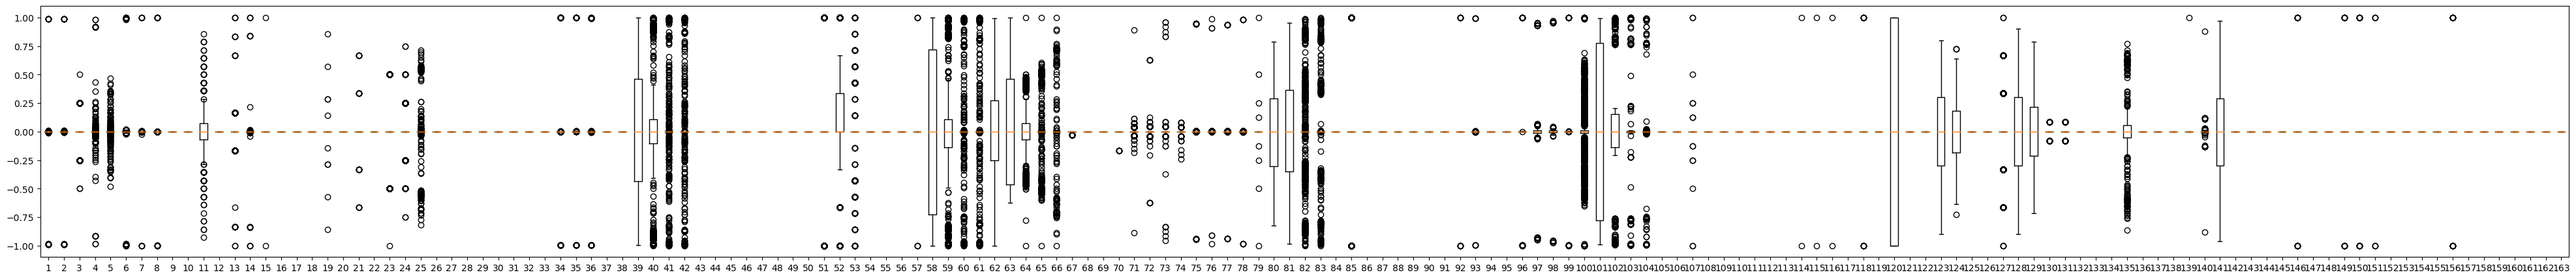

(163, 1970)


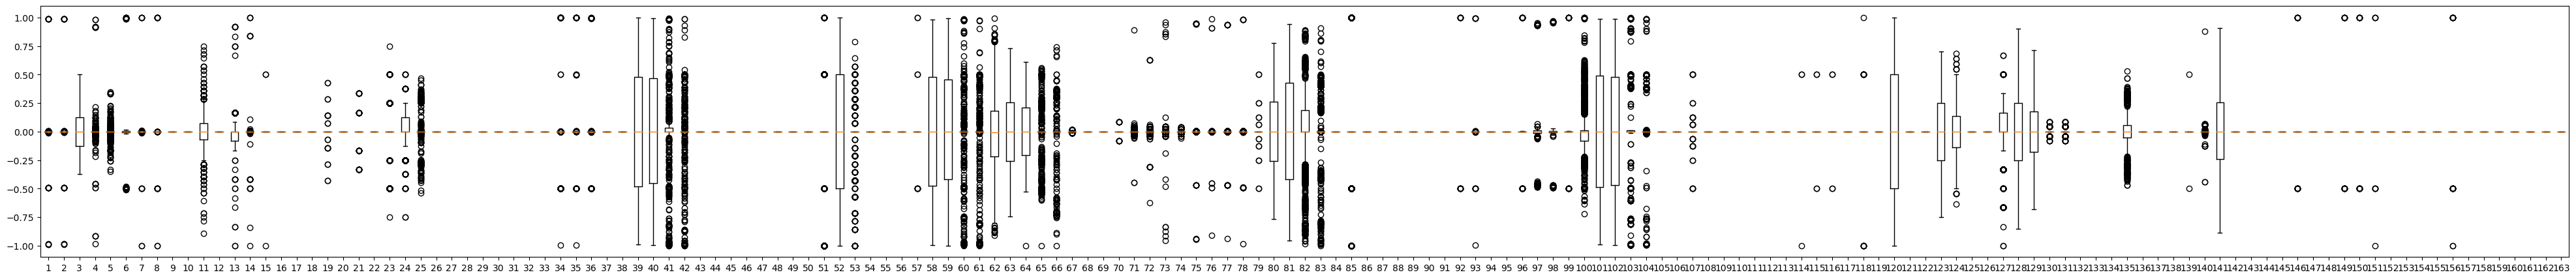

In [30]:
# 计算粗糙度和光滑度矩阵

from scipy.io import loadmat
import os
import numpy as np
import matplotlib.pyplot as plt

# 设置工作目录
download_folder_name = 'Tail_652_1'

# 设置结果存储目录
cluster_save_path = '../result/variable_cluster/rough&smooth'
if not os.path.exists(cluster_save_path):
    os.mkdir(cluster_save_path)

# 初始化pca结果存储array
roughness_matrix_list = []
smoothness_matrix_list = []

# for mat_name in os.listdir(os.path.join(download_save_path, download_folder_name)):
for mat_name in [os.listdir(os.path.join(download_save_path, download_folder_name))[0]]:
    # 载入mat文件
    mat = loadmat(os.path.join(download_save_path, download_folder_name, mat_name))
    # 将mat文件整理成(163, )的array
    wshr_data = mat["WSHR"][0][0][0]
    sampling_data_array = []
    for var_list in var_groups_dict.values():
        for var_name in var_list:
            var_data, var_rate = mat[var_name][0][0][0], mat[var_name][0][0][1][0][0]
            # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
            if var_rate == 1:
                sampling_data = var_data
            elif var_rate > 1: # 进行下采样
                sampling_data = random.sample(var_data.tolist(), k=len(wshr_data))
            else:
                sampling_data = random.choices(var_data, k=len(wshr_data))
            # 将采样数据进行min_max归一化
            if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
                sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
            else:
                sampling_data = sampling_data
            # print(np.max(sampling_data), np.min(sampling_data))
            sampling_data_array.append(sampling_data)
    summary_data_array = np.squeeze(np.array(sampling_data_array))
    
    # 计算粗糙度
    roughness_matrix = summary_data_array[:, 1:] - summary_data_array[:, :-1]
    print(roughness_matrix.shape)
    plt.figure(figsize=(50, 5))
    plt.boxplot(roughness_matrix.T)
    plt.show()
    roughness_matrix_list.append(roughness_matrix)
    # 计算光滑程度
    smoothness_matrix = (roughness_matrix[:, 1:] - roughness_matrix[:, :-1]) / 2
    print(smoothness_matrix.shape)
    plt.figure(figsize=(50, 5))
    plt.boxplot(smoothness_matrix.T)
    plt.show()
    smoothness_matrix_list.append(smoothness_matrix)

    # print(summary_data_array.shape)
    # print(roughness_matrix.shape)
    # print(smoothness_matrix.shape)

    # break

In [13]:
# # 存储粗糙度和光滑度list
# roughness_matrix_array = np.array([matrix.ravel() for matrix in roughness_matrix_list])
# smoothness_matrix_array = np.array([matrix.ravel() for matrix in smoothness_matrix_list])
# np.save(os.path.join(cluster_save_path, "roughness_matrix_array.npy"), roughness_matrix_array)
# np.save(os.path.join(cluster_save_path, "smoothness_matrix_array.npy"), smoothness_matrix_array)

C:\Users\86108\AppData\Local\Temp\ipykernel_11880\332963728.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  roughness_matrix_array = np.array([matrix.ravel() for matrix in roughness_matrix_list])
C:\Users\86108\AppData\Local\Temp\ipykernel_11880\332963728.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smoothness_matrix_array = np.array([matrix.ravel() for matrix in smoothness_matrix_list])


In [19]:
print(len(roughness_matrix_list))
print(roughness_matrix_list[0].shape)
print(np.mean(roughness_matrix_list[0], axis=1).shape)

1
(163, 1971)
(163,)


(1, 2, 163)
[[2680.459079814731], [0.7737771956845202], [0.36173135594347755]]
[[0.26, 0.23], [0.0, 0.0], [0.65, 0.56], [0.46, 0.4], [0.07, 0.07], [0.38, 0.33], [0.16, 0.13]]


d:\coding\Anaconda\Software\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


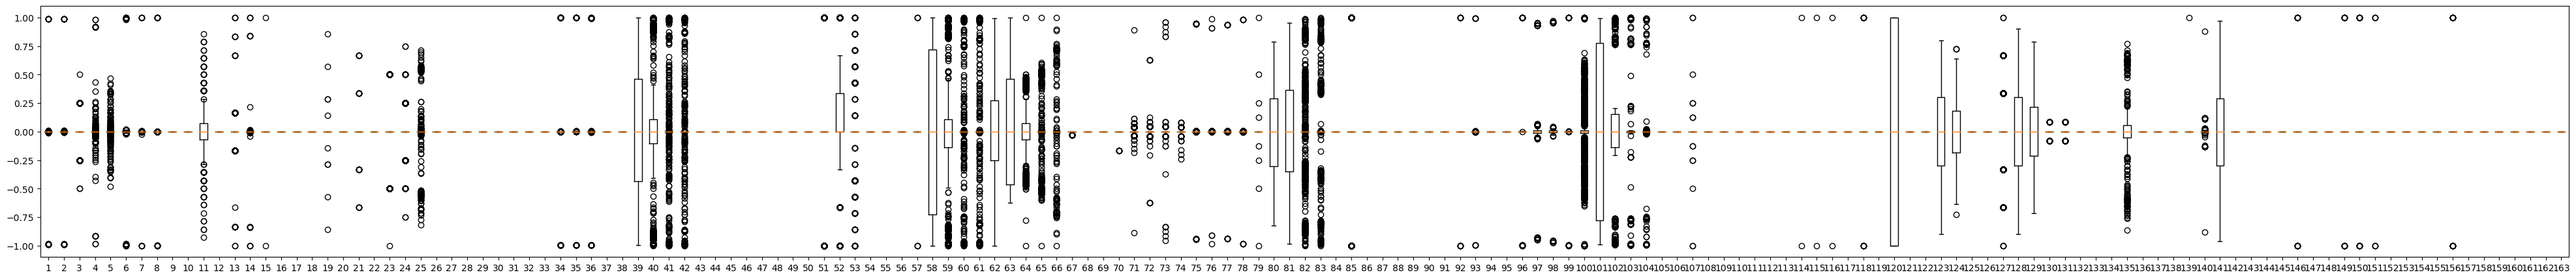

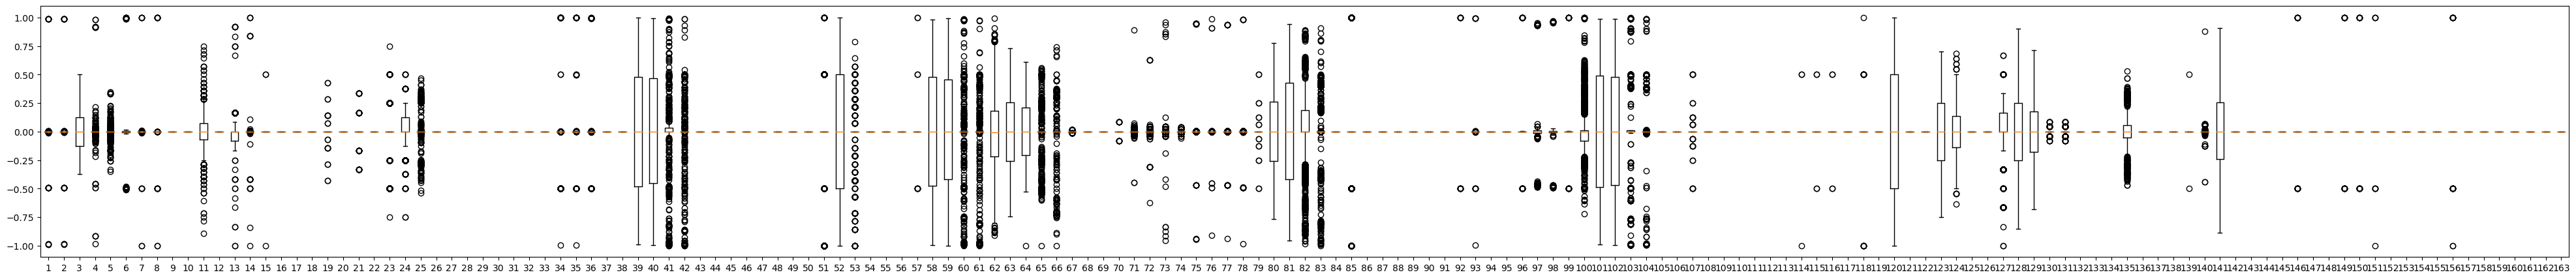

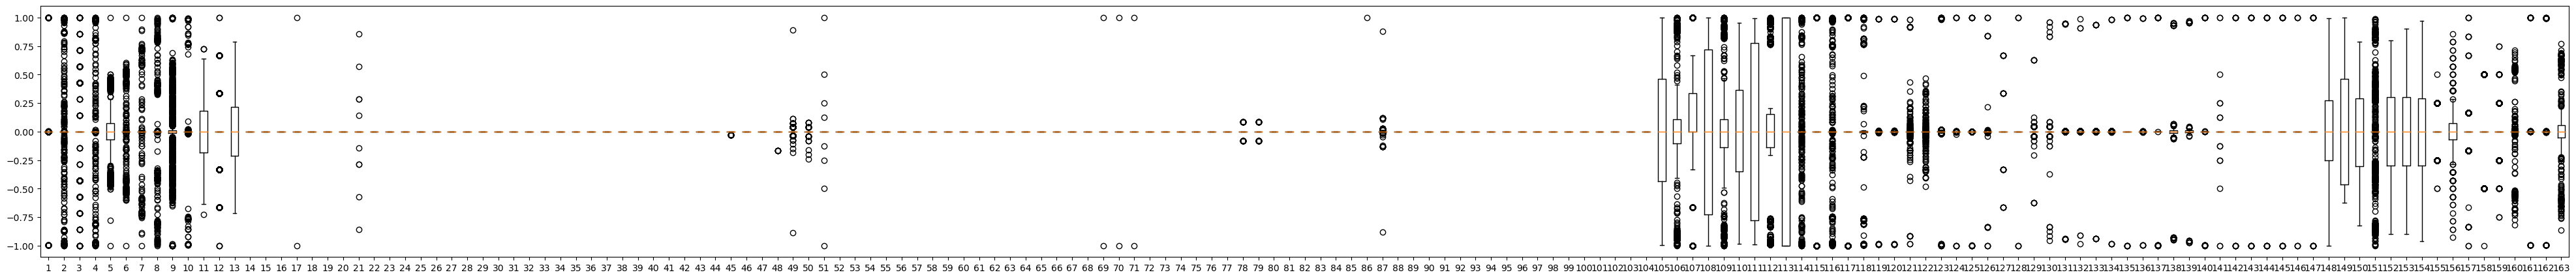

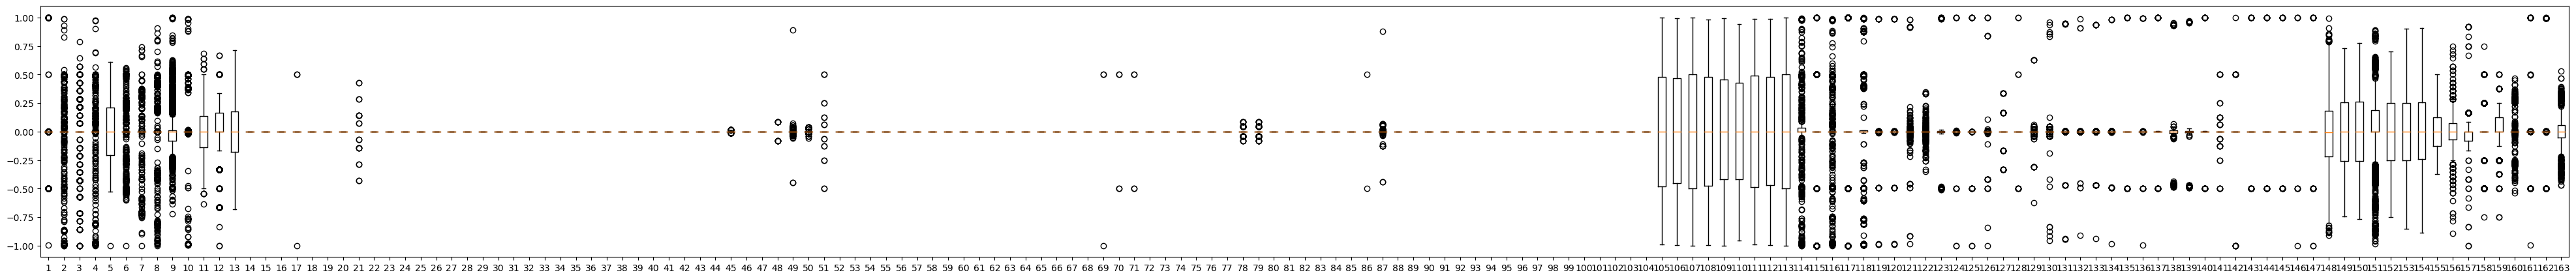

13:dict_keys([('mechanism', 'VRTG'), ('power', 'N2_4'), ('power', 'VIB_3'), ('power', 'N1_4'), ('power', 'FF_2'), ('power', 'FF_3'), ('power', 'FF_4'), ('power', 'EGT_4'), ('control', 'CWPF'), ('control', 'PLA_4'), ('external', 'ALTR'), ('external', 'PI'), ('external', 'PT')])
91:dict_keys([('mechanism', 'SPLG'), ('mechanism', 'SPLY'), ('mechanism', 'BPGR_1'), ('mechanism', 'BPYR_2'), ('mechanism', 'MSQT_1'), ('mechanism', 'MSQT_2'), ('mechanism', 'NSQT'), ('mechanism', 'BLV'), ('mechanism', 'CALT'), ('mechanism', 'WOW'), ('mechanism', 'PTCH'), ('mechanism', 'ROLL'), ('mechanism', 'TH'), ('mechanism', 'MH'), ('mechanism', 'TAS'), ('mechanism', 'CASM'), ('mechanism', 'GS'), ('mechanism', 'IVV'), ('mechanism', 'FPAC'), ('mechanism', 'CTAC'), ('power', 'ECYC_1'), ('power', 'ECYC_2'), ('power', 'ECYC_3'), ('power', 'ECYC_4'), ('power', 'EHRS_1'), ('power', 'EHRS_2'), ('power', 'EHRS_3'), ('power', 'EHRS_4'), ('power', 'VIB_4'), ('power', 'FADS'), ('power', 'HYDG'), ('power', 'FQTY_1'), ('p

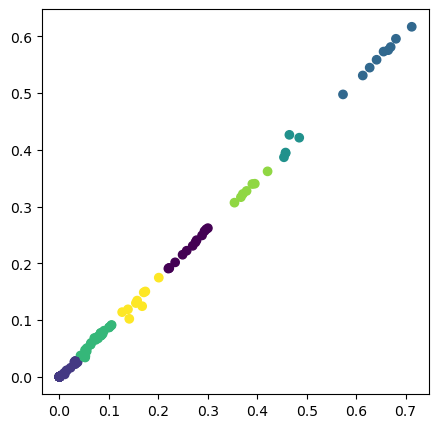

In [78]:
# 进行K-means聚类
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter

# 初始化(粗糙度，光滑度)存储列表
metrics_list = []

discrete_value = 15

# 将粗糙度和光滑度的标准差tuple作为聚类metrics
for i in range(len(roughness_matrix_list)):
    metrics_list.append([np.std(roughness_matrix_list[i], axis=1), np.std(smoothness_matrix_list[i], axis=1)])
    # metrics_list.append([np.max(roughness_matrix_list[i], axis=1), np.max(smoothness_matrix_list[i], axis=1), \
    #                      np.std(roughness_matrix_list[i], axis=1), np.std(smoothness_matrix_list[i], axis=1)])
    # metrics_list.append([[min(len(Counter(roughness_matrix_list[i][j])), discrete_value) for j in range(163)], [min(len(Counter(smoothness_matrix_list[i][j])), discrete_value) for j in range(163)], \
    #                      np.std(roughness_matrix_list[i], axis=1), np.std(smoothness_matrix_list[i], axis=1)])
metrics_array = np.array(metrics_list)

# metrics_array = np.array(roughness_matrix_list)
print(metrics_array.shape)
np.save(os.path.join(cluster_save_path, "metrics_array.npy"), metrics_array)
# metrics_array = np.load(os.path.join(cluster_save_path, "metrics_array.npy"))

# 如果我在相同聚类数量下记录每个变量的cluster编号变化，如何根据这个163*636的变化矩阵来检查哪些变量应当是同一类？

# 聚类
K = 7
metrics_array = metrics_array[0].T
cluster_labels = KMeans(n_clusters=K, random_state=9, n_init='auto').fit_predict(metrics_array)
np.save(os.path.join(cluster_save_path, "cluster_labels.npy"), cluster_labels)

# 打印聚类分数
clustering_metrics_list = [[], [], []]
clustering_metrics_list[0].append(metrics.calinski_harabasz_score(metrics_array, cluster_labels)) # 越大越好
clustering_metrics_list[1].append(metrics.silhouette_score(metrics_array, cluster_labels)) # 越大越好
clustering_metrics_list[2].append(metrics.davies_bouldin_score(metrics_array, cluster_labels)) # 越小越好
print(clustering_metrics_list)

# 输出聚类中心
cluster_centers = []
for k in range(K):
    center = np.mean(metrics_array[cluster_labels == k], axis=0)
    cluster_centers.append([round(center[0], 2), round(center[1], 2)])
print(cluster_centers)

# 重新排列roughness和smoothness的原始数据
roughness_matrix_clu, smoothness_matrix_clu = [], []
for k in range(K):
    roughness_matrix_clu.extend(roughness_matrix[cluster_labels == k])
    smoothness_matrix_clu.extend(smoothness_matrix[cluster_labels == k])
roughness_matrix_clu = np.array(roughness_matrix_clu)
smoothness_matrix_clu = np.array(smoothness_matrix_clu)

# 按类别打印roughness和smoothness的箱线图
plt.figure(figsize=(50, 5))
plt.boxplot(roughness_matrix.T)
plt.show()
plt.figure(figsize=(50, 5))
plt.boxplot(smoothness_matrix.T)
plt.show()
plt.figure(figsize=(50, 5))
plt.boxplot(roughness_matrix_clu.T)
plt.show()
plt.figure(figsize=(50, 5))
plt.boxplot(smoothness_matrix_clu.T)
plt.show()

# 输出对应变量组
for k in range(K):
    cluster_idx = np.where(cluster_labels == k)[0]
    cluster_var_name_dict = {find_var_name(idx, var_groups_dict): {'r': round(metrics_array[idx][0], 2), 's': round(metrics_array[idx][1], 2) } for idx in cluster_idx}
    if len(cluster_var_name_dict) < 163:
        print(f"{len(cluster_var_name_dict)}:{cluster_var_name_dict.keys()}")

# 可视化
plt.figure(figsize=(5, 5))
plt.scatter(metrics_array[:,0], metrics_array[:,1], c=cluster_labels)
# plt.gca().legend(labels = [f"Cluster {k}" for k in range(K)], loc='best')
plt.show()

In [ ]:
# 按照聚类标签输出各类的图片

In [60]:
from collections import Counter

print(len(cluster_labels))
print(len(Counter(roughness_matrix[2])))

163
5


In [64]:
arr = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5]
order = [1, 2, 3, 4, 5, 6, 9]
labels = [1, 1, 2, 1, 1, 2, 2, 1, 3, 4, 2]

# 方法一：使用sorted()函数创建新的排序后的列表
sorted_arr = sorted(arr, key=labels)
print(sorted_arr)

# 方法二：使用sort()方法就地排序
arr.sort(key=lambda x: order.index(x))
print(arr)


TypeError: 'list' object is not callable